# **TUTORIAL** 
## *Data-driven collective variables for enhanced sampling* 
Luigi Bonati*, Valerio Rizzi and Michele Parrinello, J. Phys. Chem. Lett., 11, 2998-3004 (2020) [doi:10.1021/acs.jpclett.0c00535](http://doi.org/10.1021/acs.jpclett.0c00535).


\* mail: luigi.bonati[at]phys.chem.ethz.ch

![alt text](https://drive.google.com/uc?id=1fxFCJWY6UWXxyNheIv4N9PPx3ouB7kID)

**INSTRUCTIONS**

- Open the notebook in playground mode
- Click on the left of the cell to execute the code or press *MAIUSC+ENTER*
- Double-click on the cells to reveal/hide the code.
- Note: the code reported here works for two states, but can be easily generalized to multi-states examples.


# Setup and methods
*Load the required modules and define the NN architecture and training functions.*


In [1]:
#@title Load modules

#############
# IMPORTANT #
#############

# currently Deep-LDA code only works with libtorch 1.4.0
# so you must use an older version of pytorch too, 
# version 1.4.0 or 1.5.0 to train the model.
# Otherwise, plumed will raise an error, saying it cant find the model.

# !pip3 install torch==1.5.0 torchvision==0.6.0

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import os
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import itertools
# import progressbar

# from google.colab import files

print("Using Pytorch",torch.__version__)

Using Pytorch 1.4.0


In [2]:
#@title Define NN architecture and loss function

##################################
# Custom Dataset 
##################################
class ColvarDataset(Dataset):
    """COLVAR dataset"""

    def __init__(self, colvar_list):
        self.nstates = len( colvar_list )
        self.colvar = colvar_list
        
    def __len__(self):
        return len(self.colvar[0])

    def __getitem__(self, idx):
        x = ()
        for i in range(self.nstates):
            x += (self.colvar[i][idx],)
        return x
    
#useful for cycling over the test dataset if it is smaller than the training set
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

##################################
# Define Networks
##################################

class NN_DeepLDA(nn.Module):
    
    def __init__(self, l ):
        super(NN_DeepLDA, self).__init__()

        modules=[]
        for i in range( len(l)-1 ):
            print(l[i],' --> ', l[i+1], end=' ')
            if( i<len(l)-2 ):
                modules.append(nn.Linear(l[i], l[i+1]) )
                modules.append( nn.ReLU(True) )
                print("(relu)")
            else:
                modules.append(nn.Linear(l[i], l[i+1]) )
                print("")
                
        self.nn = nn.Sequential(*modules)
        
        #norm option
        self.normIn = False
        
    def set_norm(self, Mean: torch.Tensor, Range: torch.Tensor):
        self.normIn = True
        self.Mean = Mean
        self.Range = Range
        
    def normalize(self, x: Variable):
        batch_size = x.size(0)
        x_size = x.size(1)
        
        Mean = self.Mean.unsqueeze(0).expand(batch_size, x_size)
        Range = self.Range.unsqueeze(0).expand(batch_size, x_size)
        
        return x.sub(Mean).div(Range)
    
    def get_hidden(self, x: Variable, svd=False, svd_vectors=False, svd_eigen=False, training=False) -> (Variable):
        if(self.normIn):
            x = self.normalize(x)   
        z = self.nn(x)
        return z

    def set_lda(self, x: torch.Tensor):
        self.lda = nn.Parameter(x.unsqueeze(0), requires_grad=False) 

    def get_lda(self) -> (torch.Tensor):
        return self.lda

    def apply_lda(self, x: Variable) -> (Variable):
        z = torch.nn.functional.linear(x,self.lda)
        return z
        
    def forward(self, x: Variable) -> (Variable):
        z = self.get_hidden(x,svd=False)
        z = self.apply_lda(z)
        return z

    def get_cv(self, x: Variable) -> (Variable):
        return self.forward(x)

# auxiliary class to export a model which outputs the topmost hidden layer
class NN_Hidden(nn.Module):
    
    def __init__(self, l ):
        super(NN_Hidden, self).__init__()
        
        modules=[]
        for i in range( len(l)-1 ):
            if( i<len(l)-2 ):
                modules.append(nn.Linear(l[i], l[i+1]) )
                modules.append( nn.ReLU(True) )
            else:
                modules.append(nn.Linear(l[i], l[i+1]) )
                
        self.nn = nn.Sequential(*modules)
        
        #norm option
        self.normIn = False
        
    def set_norm(self, Mean: torch.Tensor, Range: torch.Tensor):
        self.normIn = True
        self.Mean = Mean
        self.Range = Range
        
    def normalize(self, x: Variable):
        batch_size = x.size(0)
        x_size = x.size(1)
        Mean = self.Mean.unsqueeze(0).expand(batch_size, x_size)
        Range = self.Range.unsqueeze(0).expand(batch_size, x_size)
        return x.sub(Mean).div(Range)
    
    def get_hidden(self, x: Variable, svd=False, svd_vectors=False, svd_eigen=False, training=False) -> (Variable):
        if(self.normIn):
            x = self.normalize(x)   
        z = self.nn(x)
        return z
        
    def forward(self, x: Variable) -> (Variable):
        z = self.get_hidden(x,svd=False)
        return z

##################################
# Loss function
##################################

def LDAloss_cholesky(H, label, test_routines=False):
    #sizes
    N, d = H.shape

    # Mean centered observations for entire population
    H_bar = H - torch.mean(H, 0, True)
    #Total scatter matrix (cov matrix over all observations)
    S_t = H_bar.t().matmul(H_bar) / (N - 1)
    #Define within scatter matrix and compute it
    S_w = torch.Tensor().new_zeros((d, d), device = device, dtype = dtype)    
    S_w_inv = torch.Tensor().new_zeros((d, d), device = device, dtype = dtype)
    buf = torch.Tensor().new_zeros((d, d), device = device, dtype = dtype)
    #Loop over classes to compute means and covs
    for i in range(categ):
        #check which elements belong to class i
        H_i = H[torch.nonzero(label == i).view(-1)]
        # compute mean centered obs of class i
        H_i_bar = H_i - torch.mean(H_i, 0, True)
        # count number of elements
        N_i = H_i.shape[0]
        if N_i == 0:
            continue
        S_w += H_i_bar.t().matmul(H_i_bar) / ((N_i - 1) * categ)       

    S_b = S_t - S_w

    S_w = S_w + lambdA * torch.diag(torch.Tensor().new_ones((d), device = device, dtype = dtype))

    ## Generalized eigenvalue problem: S_b * v_i = lambda_i * Sw * v_i 

    # (1) use cholesky decomposition for S_w
    L = torch.cholesky(S_w,upper=False)

    # (2) define new matrix using cholesky decomposition and 
    L_t = torch.t(L)
    L_ti = torch.inverse(L_t)
    L_i = torch.inverse(L)
    S_new = torch.matmul(torch.matmul(L_i,S_b),L_ti)

    # (3) solve  S_new * w_i = lambda_i * w_i
    eig_values, eig_vectors = torch.symeig(S_new,eigenvectors=True)
    eig_vectors = eig_vectors.t()
    # (4) sort eigenvalues and retrieve old eigenvector 
    #eig_values, ind = torch.sort(eig_values, 0, descending=True)
    max_eig_vector = eig_vectors[-1]   
    max_eig_vector = torch.matmul(L_ti,max_eig_vector)
    norm=max_eig_vector.pow(2).sum().sqrt()
    max_eig_vector.div_(norm)

    loss = - eig_values[-1]

    return loss, eig_values, max_eig_vector, S_b, S_w

# Evaluate LDA over all the training set
def check_LDA_cholesky(loader, model):
    with torch.no_grad():
        for data in loader:
            X,y = data[0].float().to(device),data[1].long().to(device)
            H  = model.get_hidden(X)
            _, eig_values, eig_vector, _, _ = LDAloss_cholesky(H, y)
    return eig_values, eig_vector


In [3]:
#@title Encoding and plotting functions

##################################
# Encoding functions
##################################

def encode_hidden(loader,model,batch,n_hidden,device):
    """Compute the hidden layer over a dataloader"""
    s=np.empty((len(loader),batch,n_hidden))
    l=np.empty((len(loader),batch))
    for i,data in enumerate(loader):
        x,lab = data[0].float(),data[1].long()
        x = Variable(x).to(device)
        cv = model.get_hidden(x,svd=False)
        #cv = model.apply_pca(cv)
        s[i] = cv.detach().cpu().numpy()
        l[i] = lab
        
    s=s.reshape(len(loader)*batch,n_hidden)
    s=s[0:len(loader)*batch]

    l=l.reshape(len(loader)*batch)
    l=l[0:len(loader)*batch]
    
    sA = s[l==0]
    sB = s[l==1]

    return sA,sB

def encode_cv(loader,model,batch,n_cv,device):
    """Compute the CV over a dataloader"""
    s=np.empty((len(loader),batch,n_cv))
    l=np.empty((len(loader),batch))
    for i,data in enumerate(loader):
        x,lab = data[0].float(),data[1].long()
        x = Variable(x).to(device)
        cv = model(x)
        s[i] = cv.detach().cpu().numpy()
        l[i] = lab
        
    s=s.reshape(len(loader)*batch,n_cv)
    s=s[0:len(loader)*batch]

    l=l.reshape(len(loader)*batch)
    l=l[0:len(loader)*batch]
    
    sA = s[l==0]
    sB = s[l==1]

    return sA,sB

def encode_cv_all(loader,model,batch,n_cv,device):
    """Compute the CV over a dataloader with labels"""
    s=np.empty((len(loader),batch,n_cv))
    l=np.empty((len(loader),batch))
    for i,data in enumerate(loader):
        x,lab = data[0].float(),data[1].long()
        x = Variable(x).to(device)
        cv = model.get_cv(x)
        s[i] = cv.detach().cpu().numpy()
        l[i] = lab
        
    s=s.reshape(len(loader)*batch,n_cv)
    s=s[0:len(loader)*batch]

    l=l.reshape(len(loader)*batch)
    l=l[0:len(loader)*batch]

    return s,l

##################################
# Plotting functions
##################################

def plot_results(save=False,testing=False):
    fig, axes = plt.subplots(1, 3, figsize=(13,4))
    plot_training(axes[0],save)
    plot_H(axes[1],save,testing)
    plot_CV(axes[2],save,testing)
    if save:
        fig.savefig("{}/{}.png".format(tr_folder, "training"),dpi=150)
        plt.close()
    else:
        plt.show()

def plot_training(ax,save=False,training=False):
    ax.set_title("Deep-LDA optimization")
    ax.plot(np.asarray(ep),np.asarray(eig),'.-', c='tab:green', label='train-batch')
    ax.plot(np.asarray(ep),np.asarray(eig_t),'.-', c='tab:grey', label='train')
    ax.plot(np.asarray(ep),np.asarray(eig_val),'.-', c='tab:orange', label='valid')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("1st Eigenvalue")
    ax.legend()

def plot_H(ax,save=False,testing=False):
#     device = torch.device('cuda:0')
    ax.set_title("LDA on Hidden-space H")
    # -- Testing and Validation histograms --
#     model = model.cuda()
#     train_data = train_data.cuda()
    trA,trB = encode_hidden(train_all_loader,model,train_data,n_hidden,device)
    eigen=max_eig_vector.cpu().detach().numpy()

    ax.scatter(trA[:,0],trA[:,1], c='tab:red', label='train A',alpha=0.3)
    ax.scatter(trB[:,0],trB[:,1], c='tab:blue', label='train B',alpha=0.3)

    if testing:
        ttA,ttB = encode_hidden(valid_loader,model,valid_data,n_hidden,device)
        ax.scatter(ttA[:,0],ttA[:,1], c='tab:orange', label='valid A',s=0.2, alpha=0.5)
        ax.scatter(ttB[:,0],ttB[:,1], c='tab:cyan', label='valid B',s=0.2, alpha=0.5)
        mIN=np.min([np.min(trA[:,0]),np.min(trB[:,0]),np.min(ttA[:,0]),np.min(ttB[:,0])])
        mAX=np.max([np.max(trA[:,0]),np.max(trB[:,0]),np.max(ttA[:,0]),np.max(ttB[:,0])])
    else:
        mIN=np.min([np.min(trA[:,0]),np.min(trB[:,0])])
        mAX=np.max([np.max(trA[:,0]),np.max(trB[:,0])])

    ax.set_xlabel(r"$h_0$")
    ax.set_ylabel(r"$h_1$")

    #x=np.linspace(mIN,mAX,100)
    #y=-eigen[0]/eigen[1]*x+0
    #plt.plot(x,y, linewidth=2, label='DeepLDA')
    ax.legend() 

def plot_CV(ax,save=False,testing=False):
#     device = torch.device('cuda:0')
    sA,sB = encode_cv(train_all_loader,model,train_data,n_cv,device)
    sA,sB = sA[:,0], sB[:,0]
    if testing:
        stA,stB = encode_cv(valid_loader,model,valid_data,n_cv,device)
        stA,stB = stA[:,0], stB[:,0]
        min_s=np.min([np.min(sA),np.min(sB),np.min(stA),np.min(stB)])
        max_s=np.max([np.max(sA),np.max(sB),np.max(stA),np.max(stB)])
    else:
        min_s=np.min([np.min(sA),np.min(sB)])
        max_s=np.max([np.max(sA),np.max(sB)])
    
    b=np.linspace(min_s,max_s,100)

    ax.set_title("Deep-LDA CV Histogram")
    ax.hist(sA, bins=b, ls='dashed', alpha = 0.7, lw=2, color='tab:red', label='train A',density=True)
    ax.hist(sB, bins=b, ls='dashed', alpha = 0.7, lw=2, color='tab:blue', label='train B',density=True)

    if testing:
        plt.hist(stA, bins=b, ls='dashed', alpha = 0.5, lw=2, color='tab:orange', label='valid A',density=True)
        plt.hist(stB, bins=b, ls='dashed', alpha = 0.5, lw=2, color='tab:cyan', label='valid B',density=True)

    ax.legend()


# Deep-LDA Training

## **Upload data**

- Datasets can be uploaded from local, Google Drive or from the web. 

- Two files are expected, one for every class, with observations in the rows and descriptors in the columns.

- Choose the method from the **upload_from** field 

- Notes:
    - Paths are ignored when uploading from local
    - Uploading from local could be much slower than reading from GDrive or from the web.




## **Load files**

Specify dataset structure (use **from_column=1** to exclude time from COLVAR file)

In [5]:
##@title **Load files**

pdb_id = '2WI3'

base_dir = '/home/dom/Projects/Playground/machine_learning/deep-lda/bCB_g1'

n_input = 10
from_column = 1

distA = np.loadtxt(f'{base_dir}/1_unbiased/astate/COLVAR',usecols=range(from_column,from_column+n_input))
distB = np.loadtxt(f'{base_dir}/1_unbiased/bstate/COLVAR',usecols=range(from_column,from_column+n_input))

print("[Imported data]")
print("- dataA.shape:", distA.shape)
print("- dataB.shape:", distB.shape)

[Imported data]
- dataA.shape: (501, 10)
- dataB.shape: (501, 10)


## **Create datasets**

- **standardize_inputs**: normalize each inputs such that it assumes values from -1 to 1. This is achieved by computing the mean and the range of the values over the training set.

- Choose the training set size (**train_data**) and the batch size (**batch_tr**). The batch size should be large enough to give estimates of the covariance matrices which are representative of the population for the computation of LDA.

- A validation dataset (**valid_data**)) is also defined, but it is evaluated in a single batch.

In [6]:
##@title Create datasets
standardize_inputs = True #@param {type:"boolean"}

if standardize_inputs:
    print("[Standardize inputs]")
    print("- Calculating mean and range over the training set")
    Max=np.amax(np.concatenate([distA,distB],axis=0),axis=0)
    Min=np.amin(np.concatenate([distA,distB],axis=0),axis=0)

    Mean=(Max+Min)/2.
    Range=(Max-Min)/2.
    if(np.sum(np.argwhere(Range<1e-6))>0):
        print("- [Warning] Skipping normalization where range of values is < 1e-6. Input(s):", np.argwhere(Range<1e-6).reshape(-1))
        Range[Range<1e-6]=1.

# create labels
lA=np.zeros_like(distA[:,0])
lB=np.ones_like(distB[:,0])

dist=np.concatenate([distA,distB],axis=0)
dist_label=np.concatenate([lA,lB],axis=0)

p = np.random.permutation(len(dist))
dist, dist_label = dist[p], dist_label[p]

#@title Training and validation set size
train_data = int(distA.shape[0]/5) * 4 # 80% of the data for training
batch_tr = int(distA.shape[0]/5)
train_labels=ColvarDataset([dist[:train_data],dist_label[:train_data]])
train_loader=DataLoader(train_labels, batch_size=batch_tr,shuffle=True)

# create additional dataset which cover all the training set in one batch
train_all_labels=ColvarDataset([dist[:train_data],dist_label[:train_data]])
train_all_loader=DataLoader(train_all_labels, batch_size=train_data)

# The validation is evaluated in a single batch
valid_data = int(distA.shape[0]/5) # 20% for validation
batch_val=valid_data
valid_labels=ColvarDataset([dist[train_data:train_data+valid_data],dist_label[train_data:train_data+valid_data]])
valid_loader=DataLoader(valid_labels, batch_size=batch_val)

[Standardize inputs]
- Calculating mean and range over the training set


## **NN and training parameters**

Inizialize the neural network and the optimizer with the following parameters:
- **hidden_nodes**: NN architecture, specify the number of nodes per hidden layer. The last layer correspond to the space where LDA is performed. 
- **lrate**: learning rate of the optimizer (in this case, ADAM)
- **lambdA**: $S_w$ regularization
- **l2_reg**: L2 weight regularization


In [11]:
########
# NOTE #
########

# you must use CPU for training
# libtorch version I've tested is for 'cpu'
# so the model must be trained on the CPU as well
# otherwise it doesn't work

##@title NN and training parameters
#type
dtype = torch.float32
# wheter to use CUDA
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

categ = 2
n_cv=1

hidden_nodes = "50,25,5" #@param {type:"raw"}
nodes = [int(x)for x in hidden_nodes.split(',')]
nodes.insert(0, n_input)
n_hidden=nodes[-1]

print("[NN Architecture]")
print("- hidden layers:", nodes)
print("")
print("========= NN =========")
model = NN_DeepLDA(nodes)
if standardize_inputs:
    model.set_norm(torch.tensor(Mean,dtype=dtype,device=device),torch.tensor(Range,dtype=dtype,device=device))
print("======================")
model.to(device)
# if torch.cuda.is_available():
#     print("using CUDA acceleration")
#     print("========================")

# -- Optimization --
lrate = 0.001 #@param {type:"slider", min:0.0001, max:0.005, step:0.0001}
lambdA = 0.05 #@param {type:"number"}
l2_reg = 1e-5 #@param {type:"number"}
act_reg = 2./lambdA # lorentzian regularization

print("")
print("[Optimization]")
print("- Learning rate \t=",lrate)
print("- l2 regularization \t=",l2_reg)
print("- lambda (S_w reg.) \t=",lambdA)
print("- lorentian (CV reg.) \t=",act_reg)

#OPTIMIZERS
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)

#define arrays and values
ep = []
eig = []
eig_t = []
eig_val = []
init_epoch = 0
best_result = 0

[NN Architecture]
- hidden layers: [10, 50, 25, 5]

========= NN =========
10  -->  50 (relu)
50  -->  25 (relu)
25  -->  5 

[Optimization]
- Learning rate 	= 0.001
- l2 regularization 	= 1e-05
- lambda (S_w reg.) 	= 0.05
- lorentian (CV reg.) 	= 40.0


## **Training**

Set the number of epochs (**num_epochs**) and how often print the optimization details (**print_loss**) and plot the results (**plot_every**).

Notes: 
- during the training only the hidden representation h_1 vs h_2 is shown.
- if the cell is executed multiple times the training continues. To reset the NN run again the **NN and training parameters** cell.

[ ep/tot]  eig_train  eig_valid   reg loss eigenvector
[  1/100]      0.221      0.214      0.098  [0.429589 -0.434025 0.009881 0.040773 0.790769]
[  2/100]      0.332      0.323      0.179  [0.321695 -0.470407 0.092087 0.157872 0.801140]
[  3/100]      0.489      0.475      0.276  [0.232405 -0.476389 0.150609 0.233328 0.801197]
[  4/100]      0.704      0.682      0.402  [0.168884 -0.466497 0.169031 0.279229 0.804561]
[  5/100]      0.998      0.959      0.572  [0.104014 -0.477214 0.196627 0.338392 0.779921]
[  6/100]      1.409      1.335      0.898  [0.045860 -0.515263 0.220839 0.390170 0.728970]
[  7/100]      1.945      1.819      1.176  [0.009183 -0.549832 0.238289 0.408987 0.688148]
[  8/100]      2.221      2.065      1.271  [0.004079 -0.560831 0.235536 0.391697 0.690324]
[  9/100]      2.219      2.060      1.166  [0.014355 -0.558472 0.213345 0.362393 0.714883]
[ 10/100]      2.291      2.120      0.950  [0.026385 -0.572611 0.178417 0.334316 0.726512]


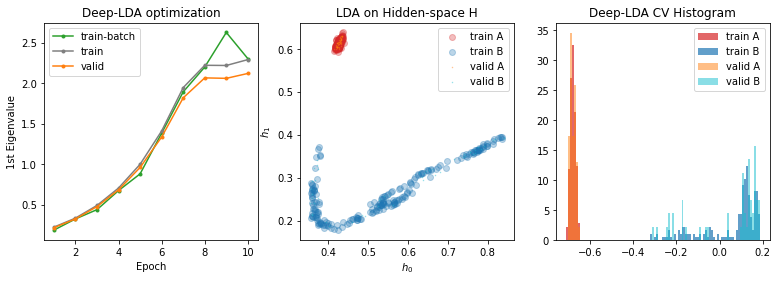

[ 11/100]      2.612      2.399      0.911  [0.018079 -0.595001 0.158012 0.321530 0.719234]
[ 12/100]      3.192      2.898      0.994  [-0.007128 -0.623020 0.147480 0.318811 0.698859]
[ 13/100]      3.866      3.471      1.066  [-0.028753 -0.647332 0.136350 0.315622 0.679651]
[ 14/100]      4.318      3.850      1.108  [-0.027792 -0.660260 0.118441 0.303804 0.675988]
[ 15/100]      4.674      4.146      1.121  [-0.014919 -0.667680 0.096308 0.286017 0.680368]
[ 16/100]      5.032      4.444      1.075  [0.004177 -0.672444 0.071146 0.263298 0.688051]
[ 17/100]      5.597      4.916      1.076  [0.017563 -0.679623 0.045665 0.240710 0.691214]
[ 18/100]      6.374      5.551      1.045  [0.024412 -0.689268 0.022216 0.220341 0.689399]
[ 19/100]      7.096      6.145      1.106  [0.038690 -0.693559 0.000182 0.197395 0.691747]
[ 20/100]      7.736      6.677      1.124  [0.059527 -0.691684 -0.018684 0.174832 0.697936]


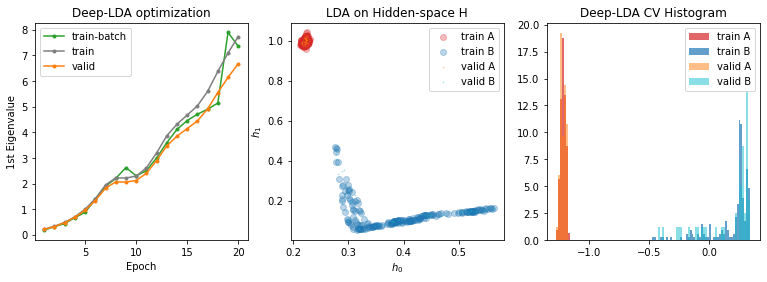

[ 21/100]      8.331      7.196      1.153  [0.082935 -0.687250 -0.036597 0.150326 0.704892]
[ 22/100]      8.979      7.784      0.952  [0.107530 -0.681571 -0.053521 0.125528 0.710828]
[ 23/100]      9.927      8.579      1.114  [0.124890 -0.675976 -0.069605 0.108468 0.714737]
[ 24/100]     10.656      9.239      1.239  [0.139057 -0.667777 -0.082927 0.097558 0.719960]
[ 25/100]     11.066      9.707      1.030  [0.154675 -0.656024 -0.093023 0.087168 0.727638]
[ 26/100]     12.153     10.681      1.113  [0.166226 -0.649821 -0.107784 0.077958 0.729662]
[ 27/100]     13.087     11.601      1.130  [0.179758 -0.641181 -0.120073 0.067890 0.733176]
[ 28/100]     13.639     12.298      1.047  [0.194381 -0.629903 -0.129051 0.057138 0.738593]
[ 29/100]     14.929     13.530      1.074  [0.207035 -0.623927 -0.143631 0.048144 0.738176]
[ 30/100]     15.668     14.393      1.090  [0.218931 -0.615729 -0.151823 0.038363 0.740557]


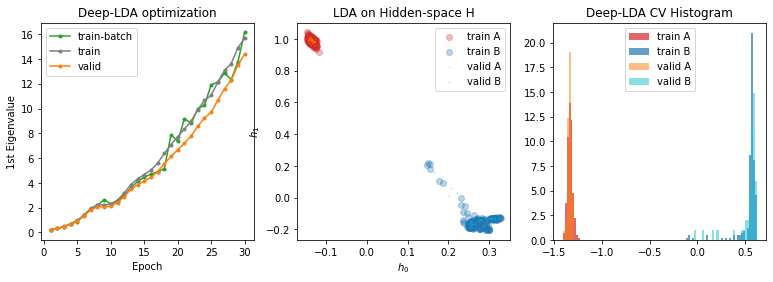

[ 31/100]     16.452     15.276      0.983  [0.229198 -0.609299 -0.159388 0.028927 0.741607]
[ 32/100]     18.069     16.745      1.173  [0.238416 -0.607131 -0.172825 0.022197 0.737691]
[ 33/100]     18.027     17.081      1.180  [0.248293 -0.598795 -0.172913 0.015193 0.741394]
[ 34/100]     18.912     18.049      0.993  [0.258268 -0.594151 -0.180370 0.009748 0.740036]
[ 35/100]     20.663     19.643      1.206  [0.266905 -0.592056 -0.193579 0.005831 0.735340]
[ 36/100]     20.292     19.705      1.148  [0.274631 -0.584185 -0.190631 0.002110 0.739568]
[ 37/100]     20.937     20.453      1.135  [0.281143 -0.580066 -0.196247 -0.000971 0.738897]
[ 38/100]     22.197     21.669      1.180  [0.286456 -0.577813 -0.206080 -0.002517 0.735935]
[ 39/100]     22.734     22.309      1.240  [0.290128 -0.574490 -0.209707 -0.003765 0.736068]
[ 40/100]     22.436     22.218      1.189  [0.292642 -0.570358 -0.208361 -0.005691 0.738652]


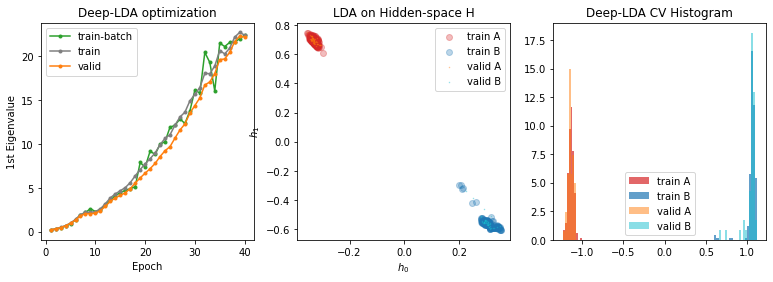

[ 41/100]     23.596     23.338      1.253  [0.294791 -0.570227 -0.215880 -0.005067 0.735738]
[ 42/100]     23.521     23.384      1.253  [0.296067 -0.568314 -0.216224 -0.005398 0.736602]
[ 43/100]     23.765     23.704      1.224  [0.296975 -0.567864 -0.218843 -0.004607 0.735814]
[ 44/100]     24.304     24.260      1.267  [0.297861 -0.568460 -0.223300 -0.003144 0.733662]
[ 45/100]     24.239     24.231      1.255  [0.298394 -0.568221 -0.224425 -0.002310 0.733290]
[ 46/100]     24.260     24.272      1.279  [0.298742 -0.567992 -0.225346 -0.001645 0.733045]
[ 47/100]     24.431     24.449      1.259  [0.298818 -0.568220 -0.226861 -0.000743 0.732371]
[ 48/100]     24.594     24.607      1.267  [0.298953 -0.568232 -0.228499 0.000173 0.731797]
[ 49/100]     24.814     24.833      1.280  [0.299207 -0.568403 -0.230856 0.001011 0.730820]
[ 50/100]     24.521     24.556      1.264  [0.299463 -0.567742 -0.231016 0.001194 0.731178]


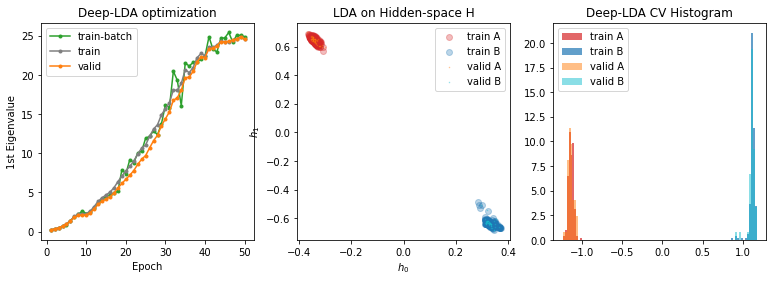

[ 51/100]     24.894     24.929      1.276  [0.300095 -0.567907 -0.234370 0.002025 0.729720]
[ 52/100]     24.920     24.947      1.269  [0.300748 -0.567495 -0.236294 0.002511 0.729150]
[ 53/100]     24.925     24.951      1.267  [0.301430 -0.567108 -0.238234 0.002637 0.728537]
[ 54/100]     25.047     25.065      1.267  [0.302177 -0.566948 -0.240759 0.002761 0.727521]
[ 55/100]     24.747     24.760      1.270  [0.302745 -0.566134 -0.241580 0.002239 0.727648]
[ 56/100]     25.063     25.088      1.279  [0.303116 -0.566257 -0.244514 0.001810 0.726418]
[ 57/100]     24.913     24.952      1.248  [0.304061 -0.565723 -0.247251 0.001144 0.725514]
[ 58/100]     25.199     25.233      1.285  [0.304405 -0.565459 -0.249778 0.000477 0.724710]
[ 59/100]     24.881     24.916      1.267  [0.304889 -0.564469 -0.250677 -0.000698 0.724967]
[ 60/100]     25.199     25.237      1.264  [0.305463 -0.564310 -0.253801 -0.001360 0.723761]


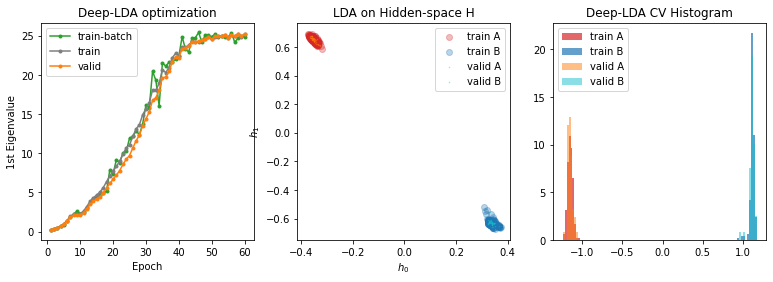

[ 61/100]     25.517     25.558      1.299  [0.305708 -0.564432 -0.256228 -0.001952 0.722705]
[ 62/100]     24.911     24.961      1.268  [0.306401 -0.563352 -0.256762 -0.003118 0.723061]
[ 63/100]     25.445     25.505      1.276  [0.306774 -0.563922 -0.260117 -0.003439 0.721255]
[ 64/100]     25.316     25.385      1.279  [0.307441 -0.563578 -0.262170 -0.004167 0.720492]
[ 65/100]     25.075     25.137      1.261  [0.307749 -0.562781 -0.263130 -0.005380 0.720626]
[ 66/100]     25.310     25.361      1.286  [0.307860 -0.562491 -0.264883 -0.006176 0.720156]
[ 67/100]     25.311     25.376      1.276  [0.308319 -0.562295 -0.266908 -0.006826 0.719359]
[ 68/100]     25.596     25.659      1.306  [0.308285 -0.562489 -0.268729 -0.007399 0.718538]
[ 69/100]     24.789     24.862      1.244  [0.309284 -0.561371 -0.269783 -0.008747 0.718573]
[ 70/100]     25.810     25.870      1.313  [0.308875 -0.562333 -0.272227 -0.008509 0.717076]


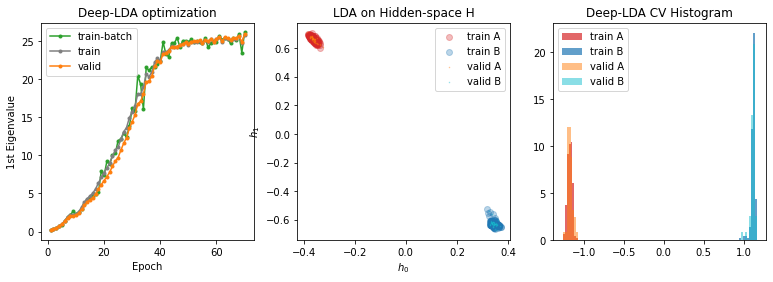

[ 71/100]     24.949     25.021      1.264  [0.309675 -0.560883 -0.272468 -0.009877 0.717757]
[ 72/100]     25.569     25.636      1.307  [0.309237 -0.561292 -0.274047 -0.009978 0.717023]
[ 73/100]     25.154     25.225      1.274  [0.309632 -0.560612 -0.275014 -0.010855 0.717002]
[ 74/100]     25.650     25.727      1.303  [0.309569 -0.560943 -0.277095 -0.010977 0.715967]
[ 75/100]     25.406     25.484      1.301  [0.309778 -0.560328 -0.277962 -0.011919 0.716007]
[ 76/100]     25.113     25.196      1.264  [0.310093 -0.559545 -0.279505 -0.013040 0.715862]
[ 77/100]     25.387     25.488      1.275  [0.310060 -0.559466 -0.281816 -0.013454 0.715024]
[ 78/100]     25.557     25.660      1.279  [0.310597 -0.559291 -0.283182 -0.013510 0.714386]
[ 79/100]     25.356     25.443      1.276  [0.310695 -0.558631 -0.283883 -0.014317 0.714567]
[ 80/100]     25.433     25.515      1.277  [0.310267 -0.558315 -0.285387 -0.015216 0.714382]


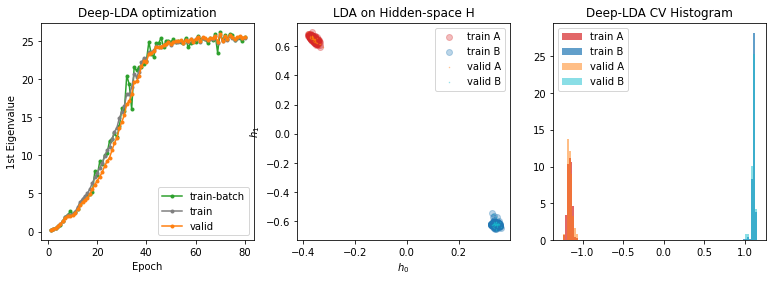

[ 81/100]     25.329     25.413      1.278  [0.310474 -0.557957 -0.286773 -0.015647 0.714007]
[ 82/100]     25.584     25.676      1.283  [0.310780 -0.558103 -0.287561 -0.015092 0.713455]
[ 83/100]     25.574     25.656      1.317  [0.310770 -0.557956 -0.287712 -0.015107 0.713513]
[ 84/100]     24.984     25.074      1.242  [0.311240 -0.557028 -0.288628 -0.016024 0.713643]
[ 85/100]     25.807     25.912      1.322  [0.310692 -0.557948 -0.290073 -0.015412 0.712590]
[ 86/100]     24.975     25.073      1.263  [0.312113 -0.556665 -0.290102 -0.016152 0.712944]
[ 87/100]     26.000     26.101      1.314  [0.311619 -0.557520 -0.291785 -0.015305 0.711823]
[ 88/100]     25.118     25.212      1.261  [0.312432 -0.555894 -0.292485 -0.016697 0.712420]
[ 89/100]     25.850     25.958      1.294  [0.312254 -0.556066 -0.294250 -0.016660 0.711637]
[ 90/100]     25.796     25.880      1.332  [0.312210 -0.555400 -0.294305 -0.017327 0.712138]


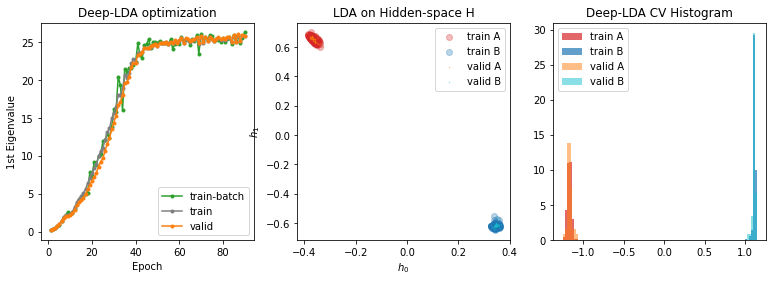

[ 91/100]     25.119     25.210      1.272  [0.312529 -0.554206 -0.294437 -0.018483 0.712844]
[ 92/100]     25.838     25.961      1.303  [0.311756 -0.555003 -0.296184 -0.018046 0.711850]
[ 93/100]     25.358     25.480      1.266  [0.312948 -0.554337 -0.296012 -0.018009 0.711917]
[ 94/100]     25.907     26.025      1.327  [0.312737 -0.554842 -0.296399 -0.017344 0.711472]
[ 95/100]     25.180     25.292      1.286  [0.313041 -0.553815 -0.296530 -0.018384 0.712058]
[ 96/100]     25.610     25.744      1.298  [0.312638 -0.554231 -0.297808 -0.018140 0.711384]
[ 97/100]     25.486     25.610      1.303  [0.313014 -0.553767 -0.298261 -0.018268 0.711387]
[ 98/100]     25.317     25.432      1.260  [0.313797 -0.553055 -0.298893 -0.018407 0.711326]
[ 99/100]     26.039     26.165      1.310  [0.313595 -0.553550 -0.299939 -0.017808 0.710606]
[100/100]     25.282     25.394      1.291  [0.314095 -0.552344 -0.299875 -0.018981 0.711319]


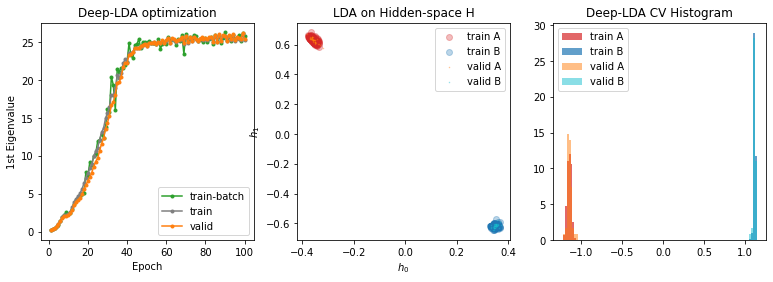

In [12]:
##@title Training
num_epochs = 100#@param {type:"number"}
print_loss = 1#@param {type:"slider", min:1, max:100, step:1}
plot_every = 10#@param {type:"slider", min:1, max:100, step:1}
plot_validation = True #@param {type:"boolean"}

#format output
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

print('[{:>3}/{:>3}] {:>10} {:>10} {:>10} {:>10}'.format('ep','tot','eig_train','eig_valid','reg loss','eigenvector'))

# -- Training --
for epoch in range(num_epochs):
    for data in train_loader:
        # =================get data===================
        X,y = data[0].float().to(device),data[1].long().to(device)
        # =================forward====================
        #H,S = model.get_hidden(X,svd=True,svd_eigen=True)
        H = model.get_hidden(X)
        # =================lda loss===================
        lossg, eig_values, max_eig_vector, Sb, Sw = LDAloss_cholesky(H, y)
        model.set_lda(max_eig_vector)  
        s = model.apply_lda(H)
        # =================reg loss===================
        reg_loss = H.pow(2).sum().div( H.size(0) )
        reg_loss_lor = - act_reg / (1+(reg_loss-1).pow(2))
        # =================backprop===================
        opt.zero_grad()
        lossg.backward(retain_graph=True)
        reg_loss_lor.backward()
        opt.step()   
    
    #Compute LDA over entire datasets and save LDA eigenvector
    train_eig_values, train_eig_vector = check_LDA_cholesky(train_all_loader, model)
    model.set_lda(train_eig_vector)
    valid_eig_values, valid_eig_vector = check_LDA_cholesky(valid_loader, model)

    #save results
    ep.append(epoch+init_epoch+1)
    eig.append(eig_values[-1])
    eig_t.append(train_eig_values[-1])
    eig_val.append(valid_eig_values[-1])

    if (epoch+1)%print_loss == 0:
        train_eig_values.cpu().detach().numpy()[-1]
#         valid_eig_values
#         train_eig_vector
        print('[{:3d}/{:3d}] {:10.3f} {:10.3f} {:10.3f} '.format
          (init_epoch+epoch+1, init_epoch+num_epochs, train_eig_values.cpu().detach().numpy()[-1], \
           valid_eig_values.cpu().numpy()[-1], reg_loss), \
              train_eig_vector.cpu().numpy() )

    if (epoch+1)%plot_every == 0:
        plot_results(testing=plot_validation)

init_epoch += num_epochs

**Inspect hidden and CV space**

Here we investigate some properties about the hidden layer and the CV.
1.   Plot the hidden components $h$ for the training set 
2.   Plot a scatter plot between each pair of them. Here we report also the projection 
3.   Export all the hidden components / CV calculated on the training set for further external analysis
4.   Print mean and std.dev. for the CV in the two basins, useful for setting the parameters of enhanced sampling




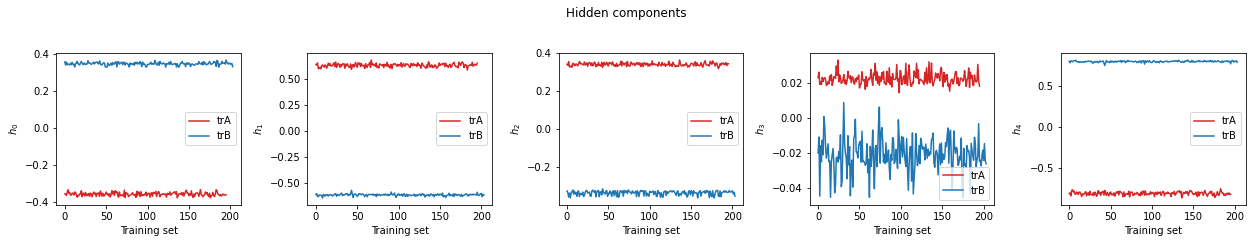

In [13]:
#@title Plot hidden components
#encode_hidden computes the hidden variables for an entire dataset, using the specified model
trA,trB = encode_hidden(train_all_loader,model,train_data,n_hidden,device)

fig, axs = plt.subplots(1, n_hidden, figsize=(3.5*n_hidden,3.5))

fig.suptitle('Hidden components')
for i in range(n_hidden):
    ax = axs[i]
    ax.set_xlabel("Training set")
    ax.set_ylabel(r"$h_"+str(i)+"$")
    ax.plot(trA[:,i], c='tab:red', label='trA')
    ax.plot(trB[:,i], c='tab:blue', label='trB')
    ax.legend()

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

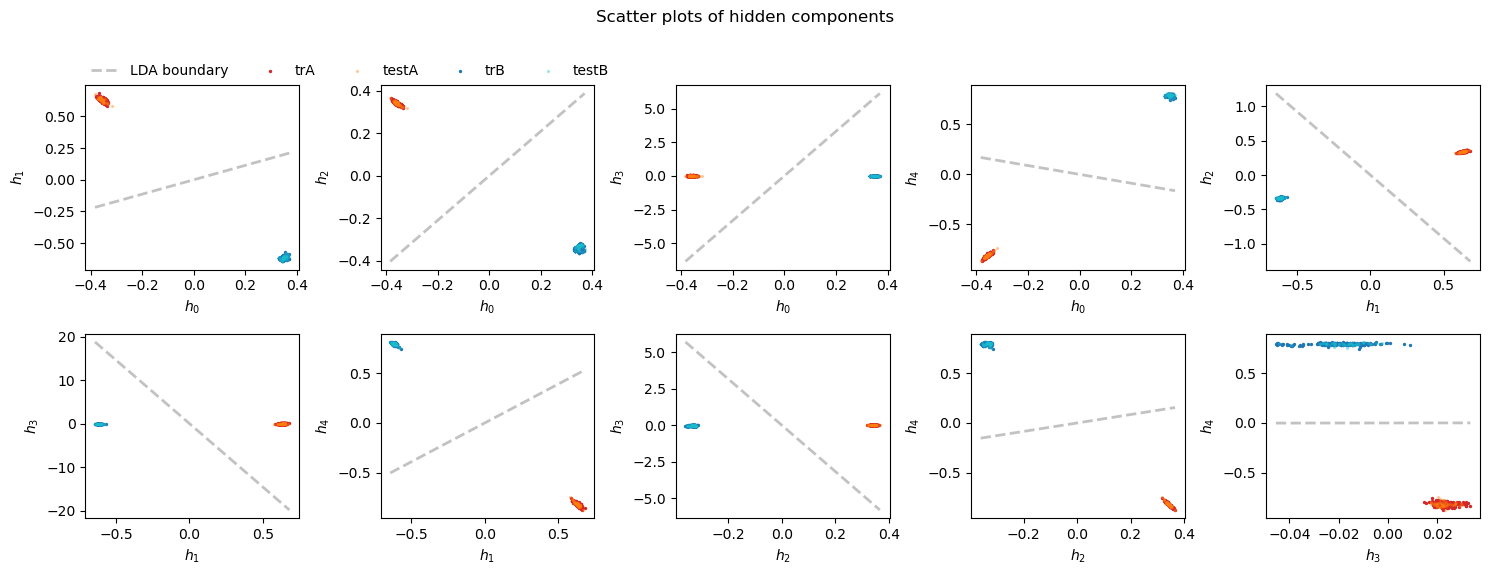

In [14]:
#@title Scatter plot w/LDA boundaries
from itertools import combinations

#get LDA eigenvector
eigen = model.get_lda().cpu().numpy()[0]

#compute h 
trA,trB = encode_hidden(train_all_loader,model,train_data,n_hidden,device)
ttA,ttB = encode_hidden(valid_loader,model,valid_data,n_hidden,device)

#plot layout
n_plots=len(list(combinations(range(n_hidden),2)))
num_plots_per_line = 5 #@param {type:"slider", min:1, max:10, step:1}
num_lines=int(n_plots/num_plots_per_line+0.999)

#define subplots
fig, axs = plt.subplots(num_lines, num_plots_per_line, figsize=(3*num_plots_per_line,3*num_lines),dpi=100)
axs = axs.reshape(-1)
fig.suptitle('Scatter plots of hidden components')

#iterate and plot
idx=0
point_size=2 #@param {type:"slider", min:0.5, max:20, step:0.5}
for i,j in combinations(range(n_hidden),2):
    ax = axs[idx]
    idx+=1
    ax.scatter(trA[:,i],trA[:,j], c='tab:red', s=point_size, label='trA')
    ax.scatter(ttA[:,i],ttA[:,j], c='tab:orange', s=point_size, label='testA',alpha=0.3,marker='o')
    ax.scatter(trB[:,i],trB[:,j], c='tab:blue', s=point_size, label='trB')
    ax.scatter(ttB[:,i],ttB[:,j], c='tab:cyan', s=point_size, label='testB',alpha=0.3,marker='o')
    #plot LDA line
    mIN=np.min([np.min(trA[:,i]),np.min(trB[:,i]),np.min(ttA[:,i]),np.min(ttB[:,i])])
    mAX=np.max([np.max(trA[:,i]),np.max(trB[:,i]),np.max(ttA[:,i]),np.max(ttB[:,i])])
    x=np.linspace(mIN,mAX,100)
    y=-eigen[i]/eigen[j]*x+0
    ax.plot(x,y, linewidth=2,  label='LDA boundary', color='darkgrey',alpha=0.7,linestyle='dashed')
    #labels
    ax.set_xlabel(r"$h_"+str(i)+"$")
    ax.set_ylabel(r"$h_"+str(j)+"$")
    if idx == 1:
        leg=ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=5, 
            borderaxespad=0, frameon=False)
        leg.set_in_layout(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [15]:
#@title Export CV and hidden variables
export_hidden = False #@param {type:"boolean"}
export_cv = False #@param {type:"boolean"}

if export_hidden:
    trA,trB = encode_hidden(train_all_loader,model,train_data,n_hidden,device)
    np.savetxt("hidden_traj_A.dat",np.transpose([ trA[:,i] for i in range(trA.shape[1]) ]))
    np.savetxt("hidden_traj_B.dat",np.transpose([ trB[:,i] for i in range(trB.shape[1]) ]))
    files.download("hidden_traj_A.dat")
    files.download("hidden_traj_B.dat")

if export_cv:
    trA,trB = encode_cv(train_all_loader,model,train_data,n_cv,device)
    np.savetxt("cv_traj_A.dat",np.transpose([ trA[:,i] for i in range(trA.shape[1]) ]))
    np.savetxt("cv_traj_B.dat",np.transpose([ trB[:,i] for i in range(trB.shape[1]) ]))
    files.download("cv_traj_A.dat")
    files.download("cv_traj_B.dat")    

In [16]:
#@title CV statistics

sA,sB = encode_cv(train_all_loader,model,train_data,n_cv,device)
sA,sB = sA[:,0], sB[:,0]

##sA=sA+sA**3
sB=sB+sB**3

print("=========== STATE A ===========")
print("- Mean   :",np.mean(sA))
print("- DevStd :",np.std(sA))
print("=========== STATE B ===========")
print("- Mean   :",np.mean(sB))
print("- DevStd :",np.std(sB))
print("===============================")



=========== STATE A ===========
- Mean   : -1.1426763571038538
- DevStd : 0.02787939200240587
=========== STATE B ===========
- Mean   : 2.494764233362864
- DevStd : 0.04868173655216319


## **Features ranking**



Compute feature importances $r_i$ by summing the modulus of the weights $w_{ij}$ of the connections between each input $i$ and each node $j$ of the first layer: 

$r_i =\sigma_i \sum_j ^{n_1}| w_{ij} ^{(1)} |$

The importances are multiplied by the standard deviations of the inputs $\sigma_i$ (disable **multiply_by_stddev** to see just the sum of the weights). In addition they are normalized such that $\sum_i r_i=1$. 

Plot setup: 
- The inputs can be ordered by the feature importances (**order_by_importance**) 
- Each feature is labelled with a number from 1 to n_inputs. In alternative, the **input names** can be specified (by enabling **use_input_names**).

**[TODO]** add doc for derivatives setup 

/home/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator


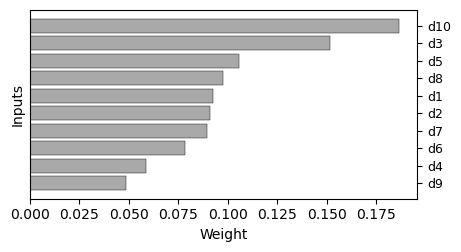

In [17]:
ranking_type = "derivatives" #@param ["weights", "derivatives"]

multiply_by_stddev = True #@param {type:"boolean"}

order_by_importance = True #@param {type:"boolean"}
use_input_names = True #@param {type:"boolean"}
input_names = "d1,d2,d3,d4,d5,d6,d7,d8,d9,d10" #@param {type:"string"}


if use_input_names:
    in_name = input_names.split(",")
    in_name = np.asarray(in_name)
else:
    in_name = np.arange(1,n_input+1)

in_num=np.arange(n_input)
rank=np.zeros(n_input)

#compute std to correct for different magnitudes
if multiply_by_stddev:
    if standardize_inputs:
        dist2=(dist-Mean)/Range
    else:
        dist2=dist
    in_std=np.std(dist2,axis=0)

#compute by summing the weights
if ranking_type == 'weights': 
    for i in range(n_input):
        rank[i]= model.nn[0].weight[:,i].abs().sum().item()

#compute by derivatives w.r.t. inputs
elif ranking_type == 'derivatives':
    for data in train_all_loader:       
        X = Variable(data[0].float().to(device),requires_grad=True)
        scv = model.get_cv(X) 
        for j in range(0,train_data,10):
            scv[j].backward(retain_graph=True)
        for i in range(n_input):   
            rank[i] += X.grad[:,i].abs().sum().item()  #ranking by derivative of the cv

#multiply by std dev
if multiply_by_stddev:
    for i in range(n_input):
        rank[i] *= in_std[i]

#sort
if order_by_importance:
    index=rank.argsort()
    in_name = in_name[index]
    rank = rank[index]

#normalize
rank/= np.sum(rank)

#plot
fig=plt.figure(figsize=(5,0.25*n_input), dpi=100)
ax = fig.add_subplot(111)

if order_by_importance:
    ax.barh(in_num, rank,color="darkgrey",edgecolor = "k",linewidth=0.3)
    ax.set_yticklabels(in_name,fontsize=9)
else:
    ax.barh(in_num[::-1], rank[::-1],color="darkgrey",edgecolor = "k",linewidth=0.3)
    ax.set_yticklabels(in_name[::-1],fontsize=9)

ax.set_xlabel('Weight')
ax.set_ylabel('Inputs')
ax.set_yticks(in_num)

#ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

## **Download model**

- By default the model is exported via the PyTorch Script interface to be loaded in PLUMED. Additional files can be exported and downloaded. 

- If the downloads don't start check if they are blocked from the browser.

In [190]:
##@title Download model

# device = torch.device('cuda:0')

model_name = "model" #@param {type:"string"}
save_hidden_layer_model = True #@param {type:"boolean"}
save_lda_coeffs = True #@param {type:"boolean"}
save_pictures = True #@param {type:"boolean"}
save_checkpoint = True #@param {type:"boolean"}

print("[Exporting the model]")

# == Set output folder
tr_folder=model_name+"/"
!mkdir -p "{tr_folder}"

# == Create fake dataloader ==
fake_loader = DataLoader(train_labels, batch_size=1,shuffle=False)
fake_input = next(iter(fake_loader ))[0].float()

# fake_input = fake_input.cuda()
# model = model.cuda()
# device = 'CUDA'

# == Export model ==
mod = torch.jit.trace(model, fake_input)
mod.save(tr_folder+model_name+".pt")
print("@@ model exported as:",model_name+".pt")

if save_hidden_layer_model:
    # == Export output components ==
    # create a copy of Deep-LDA net with a forward method that returns the hidden variables

    model2 = NN_Hidden(nodes)
#     model2 = model2.cuda()
    if standardize_inputs:
        model2.set_norm(torch.tensor(Mean,dtype=dtype,device=device),torch.tensor(Range,dtype=dtype,device=device))
    #transfer parameters
    params = model.named_parameters()
    params2 = model2.named_parameters()
    dict_params2 = dict(params2)
    for name, param in params:
        if name in dict_params2:
            dict_params2[name].data.copy_(param.data)
    # save model
    mod2 = torch.jit.trace(model2, fake_input)
    mod2.save(tr_folder+model_name+"_hidden.pt")
    print("@@ hidden components model saved as:",model_name+"_hidden.pt" )

if save_lda_coeffs:
    # == SAVE LDA COEFFICIENTS ==
    f = open(tr_folder+"lda.dat", "w")
    f.write(str(model.cpu().get_lda().numpy()))
    f.close()
    print("@@ lda coefficients saved in: lda.dat")

if save_pictures:
    # == Plot and save results == 
    plot_results(save=True,testing=True)
    print("@@ training plots saved as: training.png")

if save_checkpoint:
    # == EXPORT CHECKPOINT ==
    torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            }, tr_folder+"checkpoint")
    print("@@ checkpoint saved as: checkpoint")



# additional_files = [save_hidden_layer_model,save_lda_coeffs,save_pictures,save_checkpoint]
# if any(t == True for t in additional_files):
#     !zip -r {model_name}.zip {model_name}
#     files.download(model_name+".zip")
#     print("- Downloading zip file." )
# else:
#     files.download(tr_folder+model_name+".pt")
#     print("- Downloading model file.")


[Exporting the model]
@@ model exported as: model.pt
@@ hidden components model saved as: model_hidden.pt
@@ lda coefficients saved in: lda.dat
@@ training plots saved as: training.png
@@ checkpoint saved as: checkpoint


# Use the CV in PLUMED

In order to use the Deep-LDA CV as a collective variable to enhance the sampling, we need to import the trained model inside PLUMED.

To do so, we use Libtorch, which is the Pytorch C++ APIs library. 

Three things are necessary:
- The frozen model exported above (`model.pt`)
- A PLUMED interface to Libtorch, C++ APIs (`PytorchModel.cpp`)
- Download Libtorch and configure PLUMED against it.

**PLUMED interface**

The interface can be downloaded from [Github](https://github.com/luigibonati/data-driven-CVs/blob/master/code/PytorchModel.cpp).

It can be added in the plumed source directory (e.g. `plumed2/src/function/`) , or it can be loaded directly using the LOAD command in the PLUMED input file:

```
LOAD FILE=PytorchModel.cpp
```
Note that also in this second case we need to configure PLUMED to include the Libtorch libraries (see below).

**Libtorch installation**

Prebuilt binaries can be downloaded from Pytorch website (https://pytorch.org/). Both binaries (cxx11 ABI and pre-cxx11) can be used, despite the cxx11 ABI should be preferred.

![libtorch download](https://drive.google.com/uc?export=view&id=1nIN4pABqIk7n_xGVgHHR7A6W2Gtk3IZP)

**PLUMED configuration**

If `$LIBTORCH` contains the location of the downloaded binaries, we can configure PLUMED in the following way:

```
export LD_LIBRARY_PATH="$LIBTORCH/lib/:$LD_LIBRARY_PATH"
```
(also remember to export it in the .bashrc file, or alternatively to add `-Wl,--rpath ${LIBTORCH}/lib` in the LDFLAGS below)

```
./configure CPPFLAGS="-I\$LIBTORCH/include/torch/csrc/api/include/ -I\$LIBTORCH/include/"
LDFLAGS="-L\$LIBTORCH/lib" LIBS="-ltorch -lc10"
```
NOTE: in order to make it working with the pre-cxx11 ABI version the corresponding option should be disabled by adding the following flag to configure: 

```
CXXFLAGS="-D_GLIBCXX_USE_CXX11_ABI=0"
```

**PLUMED INPUT**

In the PLUMED input file one should specify the model and the arguments. The interface detects the number of outputs and create a component for each of them, which can be accessed as cv.node-0, cv.node-1, ... 
```
cv: PYTORCH_MODEL MODEL=model.pt ARG=d1,d2,...,dN
```




